In [1]:
import numpy as np
import cv2, os, re
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import matplotlib.image as mpimg

### Camera calibration
I start by reading all the chess board images using `calibration.add_image()` function. The "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world, is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, `calibration.obj_points` is appended with a copy of the same coordinates every time I successfully detect all chessboard corners in a test image using the function `calibration.find_corners()`. `calibration.img_points` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection. 

In [2]:
class calibration :
    def __init__(self, camera_matrix=None, dist_coefs=None) :
        self.images = {}
        self.nb_corners = {}
        self.images_with_corners = {}
        self.dim = None
        self.obj_points = None
        self.img_points = None   
        # load existing calibration if known
        self.camera_matrix = camera_matrix
        self.dist_coefs = dist_coefs
        
    def add_image(self, filename, nx, ny) :
        image = mpimg.imread(filename)
        if image is None :
            print("Failed to read {}".format(img))
        else :
            h,w = image.shape[:2]
            if not self.dim :
                self.dim = (w,h)
            else :
                if w!=self.dim[0] or h!=self.dim[1] :
                    print("Default image size is {}".format(self.dim))
                    print("whereas {} size is {}".format(filename, (w,h)))
                    print("Use with caution...")
            self.images[filename] = image
            self.nb_corners[filename] = (nx,ny)
            
    def plot_images(self, images) :
        ncols = 5
        nrows = int(np.ceil(len(images)/ncols))
        fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*5, nrows*3))
        for filename,ax in zip(images,axes.flatten()) : 
            ax.imshow(images[filename])
            ax.set_title(os.path.basename(filename))
        for ax in axes.flatten() : 
            ax.axis('off') 
            
    def display_images(self) :
        images = self.images
        self.plot_images(images)

    def display_images_with_corners(self) :
        self.find_corners(Display=True)
        images = self.images_with_corners
        self.plot_images(images)
        
        
            
    def find_corners(self, Display=False) :
        self.obj_points = []
        self.img_points = []
        self.images_with_corners = {}
        for filename, img in self.images.items() :
            nx,ny = self.nb_corners[filename]
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            found, corners = cv2.findChessboardCorners(gray, (nx, ny))
            if found:
                objp = np.zeros((nx*ny,3), np.float32)
                objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
                self.obj_points.append(objp)
                self.img_points.append(corners)
                # Draw and display the corners
                if Display :
                    img_with_corners = np.copy(img)
                    cv2.drawChessboardCorners(img_with_corners, (nx, ny), corners, found)
                    self.images_with_corners[filename] = img_with_corners
            else :
                print("Corners not found in {}".format(filename))  
                
    def calc_distortion(self) :
        self.find_corners()
        # calculate camera distortion
        rms, self.camera_matrix, self.dist_coefs, rvecs, tvecs = cv2.calibrateCamera(self.obj_points, 
                                                                    self.img_points, self.dim, None, None)
        print("RMS:", rms)
        print("camera matrix:\n", self.camera_matrix)
        print("distortion coefficients: ", self.dist_coefs.ravel())
        
    def undistort_img(self, img) :
        assert (self.camera_matrix is not None) and (self.dist_coefs is not None), "Calibrate the camera first." 
        return cv2.undistort(img, self.camera_matrix, self.dist_coefs, None, self.camera_matrix)
        
    def display_undistorted_images(self,files=None) :
        dist = {}
        undist = {}
        if not files :
            files = self.images.keys()
        for filename in files :
            img = mpimg.imread(filename)
            dist[filename] = img
            undist[filename] = cv2.undistort(img, self.camera_matrix, self.dist_coefs, None, self.camera_matrix)
        ncols = 2
        nrows = len(dist)
        fig, axes = plt.subplots(nrows,2, figsize=(ncols*4, nrows*2.5))
        for filename,ax in zip(dist,axes) : 
            ax[0].imshow(dist[filename])
            ax[1].imshow(undist[filename])
            ax[0].set_title(os.path.basename(filename)+" (original)")
            ax[1].set_title(os.path.basename(filename)+" (undistorted)")
        for ax in axes.flatten() : 
            ax.axis('off') 

Corners for all but three of the images were detected :

Default image size is (1280, 720)
whereas camera_cal/calibration7.jpg size is (1281, 721)
Use with caution...
Default image size is (1280, 720)
whereas camera_cal/calibration15.jpg size is (1281, 721)
Use with caution...
Corners not found in camera_cal/calibration5.jpg
Corners not found in camera_cal/calibration1.jpg
Corners not found in camera_cal/calibration4.jpg


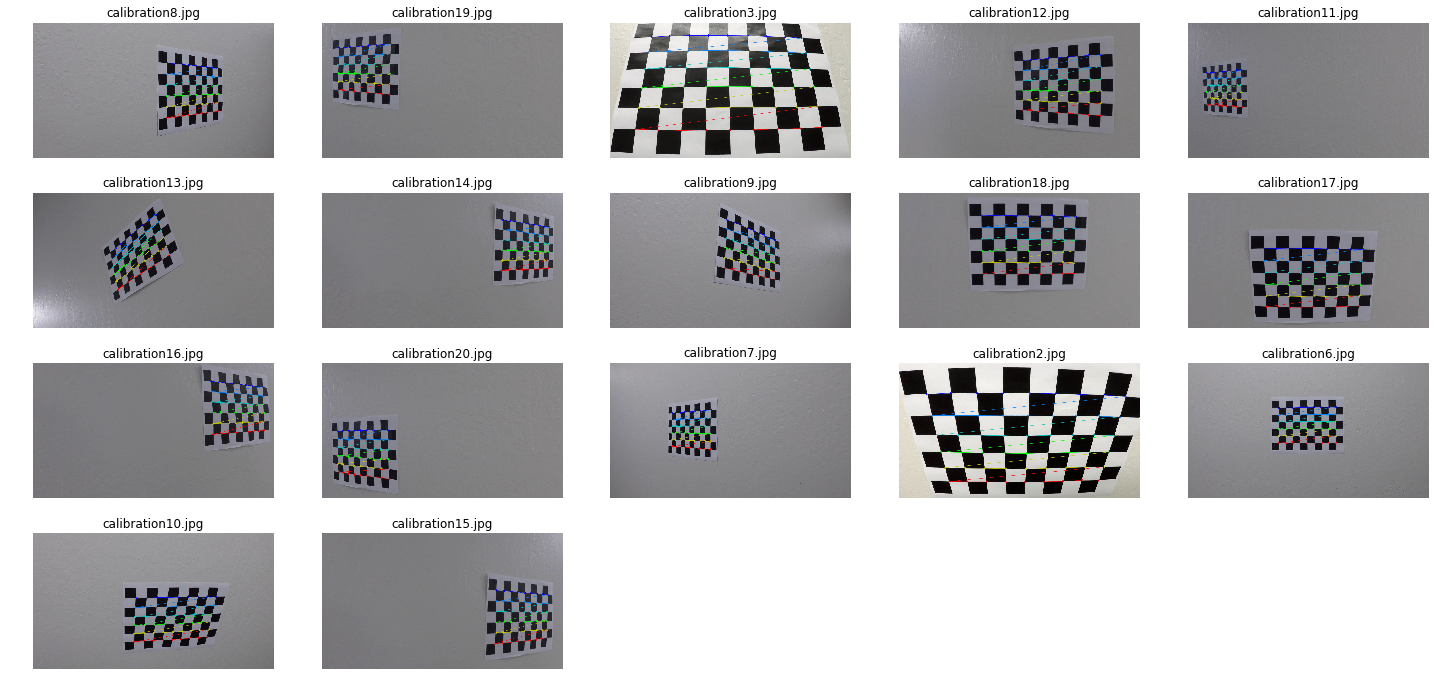

In [3]:
calib_DIR = "camera_cal"
calib_imgs = glob(os.path.join(calib_DIR,"calibration*.jpg"))
cal = calibration()
for calib_img in calib_imgs :
    nx, ny = 9,6
    cal.add_image(calib_img, nx,ny)
cal.display_images_with_corners()

Note that three of the images did not have all the 9x6 corners which will be used to test calibration.

I then used the output `calibration.obj_points` and `calibration.img_points` to compute the camera calibration and distortion coefficients in the function using the `cv2.calibrateCamera()` function (please see `calibration.calc_distortion()` for details). I applied this distortion correction to the test image using the `cv2.undistort()` function (please see `calibration.undistort_img()` for details) and obtained the following result for the three test images : 

Corners not found in camera_cal/calibration5.jpg
Corners not found in camera_cal/calibration1.jpg
Corners not found in camera_cal/calibration4.jpg
RMS: 1.1868973603423698
camera matrix:
 [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
distortion coefficients:  [ -2.41017956e-01  -5.30721171e-02  -1.15810354e-03  -1.28318858e-04
   2.67125302e-02]


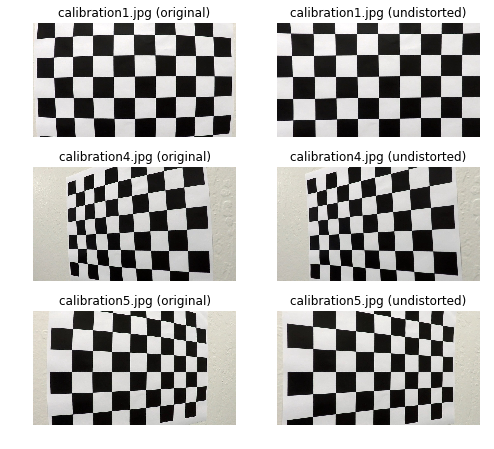

In [4]:
cal.calc_distortion()
files = [os.path.join(calib_DIR,"calibration"+str(i)+".jpg") for i in [1,4,5]]
cal.display_undistorted_images(files=files)

In [5]:
class lane_detection :
    def __init__(self, image) :
        self.img = image
        
    def warper(self, img=None, src=None, dst=None, debug=False) :
        img = self.img if img is None else img
        h,w = img.shape[:2]
        self.src = src
        self.dst = dst
        if src is None : 
            self.src = np.float32([[220,700],[595,450],[685,450],[1060,700]])
        if dst is None :
            self.dst = np.float32([[w/4,h],[w/4,-100],[3*w/4,-100],[3*w/4,h]]) 
        M = cv2.getPerspectiveTransform(self.src, self.dst)
        warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_NEAREST)
        # use debug to draw lines 
        if debug :
            pts = np.int32(self.src)
            pts = pts.reshape((-1,1,2))
            annotated_img = np.copy(img)
            annotated_img = cv2.polylines(annotated_img,[pts],True,(255,0,0), thickness=5)
            warped = cv2.line(warped,(int(w/4),h),(int(w/4),-100),(255,0,0), thickness=5)
            warped = cv2.line(warped,(int(3*w/4),h),(int(3*w/4),-100),(255,0,0), thickness=5)
            return (annotated_img, warped)
        else :
            return warped
        
    def split_channels(self) :
        """
        returns a total of 7 channels : 
        4 edge channels : all color edges (including the signs), yellow edges (including the signs) 
        3 color channels : yellow and white (2 different thresholds are used for white) 
        """
        binary = {}  
        
        # thresholding parameters for various color channels and Sobel x-gradients
        h_thresh=(15, 35)
        s_thresh=(75, 255) #s_thresh=(30, 255)
        v_thresh=(175,255)
        vx_thresh = (20, 120)
        sx_thresh=(10, 100)

        img = np.copy(self.img)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
        h_channel = hsv[:,:,0]
        s_channel = hsv[:,:,1]
        v_channel = hsv[:,:,2]

        # Sobel x for v-channel
        sobelx_pos = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
        sobelx_neg = np.copy(sobelx_pos)
        sobelx_pos[sobelx_pos<=0] = 0
        sobelx_neg[sobelx_neg>0] = 0
        sobelx_neg = np.absolute(sobelx_neg)
        scaled_sobel_pos = np.uint8(255*sobelx_pos/np.max(sobelx_pos))
        scaled_sobel_neg = np.uint8(255*sobelx_neg/np.max(sobelx_neg))
        vxbinary_pos = np.zeros_like(v_channel)
        vxbinary_pos[(scaled_sobel_pos >= vx_thresh[0]) & (scaled_sobel_pos <= vx_thresh[1])] = 1
        binary['edge_pos'] = vxbinary_pos
        vxbinary_neg = np.zeros_like(v_channel)
        vxbinary_neg[(scaled_sobel_neg >= vx_thresh[0]) & (scaled_sobel_neg <= vx_thresh[1])] = 1
        binary['edge_neg'] = vxbinary_neg

        # Sobel x for s-channel
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
        sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*sobelx/np.max(sobelx))
        sxbinary_pos = np.zeros_like(s_channel)
        sxbinary_neg = np.zeros_like(s_channel)
        sxbinary_pos[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) 
                     & (scaled_sobel_pos >= vx_thresh[0]-10) & (scaled_sobel_pos <= vx_thresh[1])]=1
        sxbinary_neg[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) 
                     & (scaled_sobel_neg >= vx_thresh[0]-10) & (scaled_sobel_neg <= vx_thresh[1])]=1           
        binary['yellow_edge_pos'] = sxbinary_pos
        binary['yellow_edge_neg'] = sxbinary_neg

        # color thresholds for selecting white lines
        v_binary = np.zeros_like(v_channel)
        v_binary[(v_channel >= v_thresh[0]+s_channel+20) & (v_channel <= v_thresh[1])] = 1
        binary['white_tight'] = np.copy(v_binary)
        v_binary[v_channel >= v_thresh[0]+s_channel] = 1
        binary['white_loose'] = v_binary

        # color threshold for selecting yellow lines
        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]) & (s_channel >= s_thresh[0])] = 1
        binary['yellow'] = h_binary

        return binary
    
    def get_nonzero_pixels(self) :
        nonzero_x, nonzero_y = {},{}
        for channel in self.binary :
            nonzero = self.binary[channel].nonzero()
            nonzero_x[channel], nonzero_y[channel] = (np.array(nonzero[1]), np.array(nonzero[0]))
        return nonzero_x, nonzero_y

    
    def get_good_pixels(self, roi, min_pix=100, max_pix=10000, window_search=True, debug=False) :
        nb_pixels, x_mean, x_stdev = {},{},{}
        for channel in self.binary :
            nonzero_x, nonzero_y = self.nonzero_x[channel], self.nonzero_y[channel]
            # region of interest
            roi_ = roi[channel]
            count = np.sum(roi_)
            if count<min_pix or (count>max_pix and window_search) :
                continue
#             if count>20000 :
#                 continue
            nb_pixels[channel] = count
            x_mean[channel]    = np.mean(nonzero_x[roi_])
            x_stdev[channel]   = np.std(nonzero_x[roi_])
            if debug :
                print(channel, count, x_mean[channel], x_stdev[channel])
        
        if window_search :
            selected_channels = [c for c in x_stdev.keys() if x_stdev[c]<35]
        else :
            selected_channels = [c for c in x_stdev.keys()]
        # some consistency checks to select channels
        if 'edge_pos' in selected_channels :
            if ('edge_neg' not in x_stdev.keys()) :
                selected_channels.remove('edge_pos')
            elif (nb_pixels['edge_neg'] < nb_pixels['edge_pos']/3) or \
                    (abs(x_mean['edge_neg']-x_mean['edge_pos'])>50) :
                selected_channels.remove('edge_pos')
                if 'edge_neg' in selected_channels : selected_channels.remove('edge_neg')
            elif window_search and (x_mean['edge_pos'] > x_mean['edge_neg']) :
                selected_channels.remove('edge_pos')
                if 'edge_neg' in selected_channels : selected_channels.remove('edge_neg')
        if 'edge_neg' in selected_channels :
            if ('edge_pos' not in x_stdev.keys()) :
                selected_channels.remove('edge_neg')
            elif (nb_pixels['edge_pos'] < nb_pixels['edge_neg']/3) or \
                    (abs(x_mean['edge_neg']-x_mean['edge_pos'])>50) :
                if 'edge_pos' in selected_channels : selected_channels.remove('edge_pos')
                selected_channels.remove('edge_neg')
            elif window_search and (x_mean['edge_pos'] > x_mean['edge_neg']) :
                selected_channels.remove('edge_neg')
                if 'edge_pos' in selected_channels : selected_channels.remove('edge_pos')
        if 'yellow_edge_pos' in selected_channels :
            if ('yellow_edge_neg' not in x_stdev.keys()) :
                selected_channels.remove('yellow_edge_pos')
            elif (nb_pixels['yellow_edge_neg']< nb_pixels['yellow_edge_pos']/3) or \
                    (abs(x_mean['yellow_edge_neg']-x_mean['yellow_edge_pos'])>50) :
                if 'yellow_edge_neg' in selected_channels : selected_channels.remove('yellow_edge_neg')
                selected_channels.remove('yellow_edge_pos')
            elif ('yellow' in selected_channels) and (abs(x_mean['yellow']-x_mean['yellow_edge_pos'])>20):
                selected_channels.remove('yellow_edge_pos')
        if 'yellow_edge_neg' in selected_channels :
            if ('yellow_edge_pos' not in x_stdev.keys()) :
                selected_channels.remove('yellow_edge_neg')
            elif (nb_pixels['yellow_edge_pos']< nb_pixels['yellow_edge_neg']/3) or \
                    (abs(x_mean['yellow_edge_pos']-x_mean['yellow_edge_neg'])>50) : 
                selected_channels.remove('yellow_edge_neg')
                if 'yellow_edge_pos' in selected_channels : selected_channels.remove('yellow_edge_pos')
            elif ('yellow' in selected_channels) and (abs(x_mean['yellow']-x_mean['yellow_edge_neg'])>20):
                selected_channels.remove('yellow_edge_neg')
        if ('white_tight' in selected_channels) :
            if 'white_loose' in selected_channels : selected_channels.remove('white_loose')
            if nb_pixels['white_tight']>8000 or (window_search and nb_pixels['white_tight']>2000) :
                selected_channels.remove('white_tight')
        if 'white_loose' in selected_channels and (nb_pixels['white_loose']<100 or nb_pixels['white_loose']>5000):  
            selected_channels.remove('white_loose')
        if window_search and 'white_loose' in selected_channels and nb_pixels['white_loose']>500 : 
            selected_channels.remove('white_loose')
        if len(selected_channels)==1 and 'yellow' in selected_channels and nb_pixels['yellow']<300 :
            selected_channels.remove('yellow')
        
        if debug :
            print("selected " , selected_channels)
        
        # combine the selected channels
        comb_nonzero_x, comb_nonzero_y = [],[]
        for channel in selected_channels :
            nonzero_x, nonzero_y = self.nonzero_x[channel], self.nonzero_y[channel]
            roi_ = roi[channel]
            comb_nonzero_x.append(nonzero_x[roi_])
            comb_nonzero_y.append(nonzero_y[roi_])
        if comb_nonzero_x :
            return (True, np.concatenate(comb_nonzero_x), np.concatenate(comb_nonzero_y))
        else :
            return (False,None,None)
        
    def window_analysis(self, X1, Y1, X2, Y2) :
        found         = {'left':None, 'right':None}
        good_pixels_x = {'left':None, 'right':None}
        good_pixels_y = {'left':None, 'right':None}
        
        for side in ['left','right'] :
            # define region of interest
            roi={}
            for channel in self.binary :
                nonzero_x, nonzero_y = self.nonzero_x[channel], self.nonzero_y[channel]
                roi[channel] = ((nonzero_x>X1[side]) & (nonzero_x<X2[side]) & (nonzero_y>Y1) & (nonzero_y<=Y2))

            found[side], good_pixels_x[side], good_pixels_y[side] = self.get_good_pixels(roi) 

        if found['left'] or found['right'] :
            self.margin['left']  = 50 if (found['left'])  else 150
            self.margin['right'] = 50 if (found['right']) else 150
            self.x_current['left']  = np.mean(good_pixels_x['left'])  if found['left'] \
                                    else np.mean(good_pixels_x['right']) -min(600, self.lane_gap)
            self.x_current['right'] = np.mean(good_pixels_x['right']) if found['right'] \
                                    else np.mean(good_pixels_x['left'])  +min(600, self.lane_gap)
            for side in ['left','right'] : self.x_current[side] = np.int(self.x_current[side])
            if found['left'] or found['right'] :
                self.lane_gap = (self.lane_gap + self.x_last_found['right'] - self.x_last_found['left'])/2
        else :
            self.margin['left']=150 
            self.margin['right']=150
            
        return found, good_pixels_x, good_pixels_y
    
    
    def check_lanes(self, img_range, min_lane_gap=350, max_lane_gap=750) :
        if self.lane_gap < min_lane_gap : return False 
        if self.lane_gap > max_lane_gap : return False
        elif self.x_current['left']<img_range[0] or self.x_current['right']>img_range[1] : return False
        else : return True
    
    
    def sliding_window(self, nb_windows=15, visualize=True, debug=False) :
        
        # get channels and warp them
        self.binary = self.split_channels()
        self.binary = {k: self.warper(v) for k, v in self.binary.items()}
        
        # group A consists of all line edges and white color 
        group_A = np.dstack((self.binary['edge_pos'], self.binary['edge_neg'], self.binary['white_loose']))
        # group B consists of yellow edges and yellow color
        group_B = np.dstack((self.binary['yellow_edge_pos'], self.binary['yellow_edge_neg'], self.binary['yellow']))
        
        if visualize :
            out_img_A = np.copy(group_A)*255
            out_img_B = np.copy(group_B)*255
            out_img_C = np.zeros_like(out_img_A)
        
        # number of windows 
        nwindows = nb_windows
        
        h,w = group_A.shape[:2]
        self.dims = (w,h)
        window_height = np.int(h/nwindows)
        midpoint = np.int(w/2)
        # width of the windows +/- margin
        self.margin = {'left' : np.int(0.5*midpoint), 
                       'right': np.int(0.5*midpoint)}
        # center of current left and right windows
        self.x_current = {'left' : np.int(0.5*midpoint), 
                          'right': np.int(1.5*midpoint)}
        # center of left and right windows last found
        self.x_last_found = {'left' : np.int(0.5*midpoint), 
                             'right': np.int(1.5*midpoint)}
        # center of previous left and right windows
        x_prev = {'left' : None, 
                  'right': None}
        
        self.nonzero_x, self.nonzero_y = self.get_nonzero_pixels() 
        # good pixels
        self.good_pixels_x = {'left' : [], 'right' : []} 
        self.good_pixels_y = {'left' : [], 'right' : []} 
        
        self.lane_gap = 600
        momentum    = {'left' :0, 
                       'right':0}
        last_update = {'left' :0, 
                       'right':0}
        self.found  = {'left' :False, 
                       'right':False}
        
        # Step through the windows one by one
        for window in range(nwindows):
            
            # Identify window boundaries in x and y (and right and left)
            Y1 = h - (window+1)*window_height
            Y2 = h - window*window_height
            X1 = {side : self.x_current[side]-self.margin[side] for side in ['left','right']} 
            X2 = {side : self.x_current[side]+self.margin[side] for side in ['left','right']} 
            if debug :
                print("-----",window, X1, X2, Y1, Y2)
            
            found, good_pixels_x, good_pixels_y = self.window_analysis(X1,Y1,X2,Y2)
            if not self.check_lanes(min_lane_gap=350, img_range=(-50,w+50)) : 
                break
            x_current = {'left' : self.x_current['left'], 'right':self.x_current['left']}
            lane_gap = self.lane_gap
            
                
            # final window refinement with updated centers and margins
            Y1 = h - (window+1)*window_height
            Y2 = h - window*window_height
            X1 = {side : self.x_current[side]-self.margin[side] for side in ['left','right']} 
            X2 = {side : self.x_current[side]+self.margin[side] for side in ['left','right']} 
            if debug :
                print("-----",window, X1, X2, Y1, Y2)
            
            
            found, good_pixels_x, good_pixels_y = self.window_analysis(X1,Y1,X2,Y2)
            if not self.check_lanes(min_lane_gap=350, img_range=(-50,w+50)) : 
                break
            
#             if (not found['left']) and (not found['right']) :
#                 self.x_current = x_current
#                 self.lane_gap = lane_gap
            
            for i,side in enumerate(['left','right']) :
                # Add good pixels to list
                if found[side] :
                    self.good_pixels_x[side].append(good_pixels_x[side])
                    self.good_pixels_y[side].append(good_pixels_y[side])
                    self.x_last_found[side] = self.x_current[side]
                
                # Draw the windows on the visualization image
                if visualize :
                    cv2.rectangle(out_img_A,(X1[side],Y1) ,(X2[side],Y2) ,(0,255,i*255), 2)  
                    cv2.rectangle(out_img_B,(X1[side],Y1) ,(X2[side],Y2) ,(0,255,i*255), 2) 
                    # Draw good pixels 
                    out_img_C[good_pixels_y[side], good_pixels_x[side],i] = 255 
            
                # decide window centers based on previous windows 
                #momentum[side] = 0
                last_update[side] += 1
                if x_prev[side] :
                    momentum[side] = np.int(momentum[side]) 
                    if found[side] :
                        momentum[side] += np.int(0.5*(self.x_current[side] - x_prev[side])/(last_update[side]))
                if found[side] : 
                    x_prev[side] = self.x_current[side]
                    last_update[side] = 0
                self.x_current[side] += momentum[side]
        
        for side in ['left','right'] :
            if self.good_pixels_x[side] :
                self.found[side] = True
                self.good_pixels_x[side] = np.concatenate(self.good_pixels_x[side])
                self.good_pixels_y[side] = np.concatenate(self.good_pixels_y[side])
            else :
                self.good_pixels_x[side] = None
                self.good_pixels_y[side] = None
        if visualize :
            return out_img_A.astype(np.uint8), out_img_B.astype(np.uint8), out_img_C.astype(np.uint8)
    
    
    def curve_fit(self, poly_order=2):
        # fit data
        fit={'left':None, 'right':None}
        
        for side in ['left','right'] :
            if self.good_pixels_x[side] is not None :
                fit[side]  = np.polyfit(self.good_pixels_y[side], self.good_pixels_x[side], poly_order)
        self.fit = fit
        return poly_order, fit
    
    
    def radius_of_curvature(self, fit, y) :
        return ((1 + (2*fit[0]*y + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    
    def plot_curve_fits(self) :
        poly_order, fit = self.curve_fit()
        h = self.dims[1]
        y = np.linspace(0, h-1, h)
        x_fit = {'left':None, 'right':None}
        for side in ['left','right'] :
            if fit[side] is not None :
                x_fit[side] = fit[side][poly_order]
                for i in range(poly_order) :
                    x_fit[side] += fit[side][i]*y**(poly_order-i)
        return x_fit,y
    
    def plot_lane(self, fit, poly_order=2) :
        #poly_order, fit = self.curve_fit()
        w,h = self.dims
        y = np.linspace(0, h-1, h)
        x_fit = {'left':None, 'right':None}
        for side in ['left','right'] :
            if fit[side] is not None :
                x_fit[side] = fit[side][poly_order]
                for i in range(poly_order) :
                    x_fit[side] += fit[side][i]*y**(poly_order-i)
                x_fit[side] = x_fit[side]
                    
        if (x_fit['left'] is not None) and (x_fit['right'] is not None) :
            lane_img = np.zeros((h,w+300,3))
            pts_x = np.hstack((x_fit['left'],x_fit['right'][::-1]))
            pts_y = np.hstack((y,y[::-1]))
            pts = np.vstack((pts_x, pts_y)).T

            cv2.fillPoly(lane_img, np.int32([pts]), (0,255, 0))

            # unwarp image
            Minv = cv2.getPerspectiveTransform(self.dst, self.src)
            lane_img = cv2.warpPerspective(lane_img, Minv, (self.img.shape[1], self.img.shape[0]))
            out_img = cv2.addWeighted(self.img, 1, np.uint8(lane_img), 0.3, 0)
            return out_img
        else :
            return self.img
        
    def target_search(self, fit, poly_order=2, margin=80, visualize=True) :
        # get channels and warp them
        self.binary = self.split_channels()
        self.binary = {k: self.warper(v) for k, v in self.binary.items()}
        
        # group A consists of all line edges and white color 
        group_A = np.dstack((self.binary['edge_pos'], self.binary['edge_neg'], self.binary['white_tight']))
        # group B consists of yellow edges and yellow color
        group_B = np.dstack((self.binary['yellow_edge_pos'], self.binary['yellow_edge_neg'], self.binary['yellow']))
        
        h,w = group_A.shape[:2]
        self.dims = (w,h)
        
        if visualize :
            out_img_A = np.copy(group_A)*255
            out_img_B = np.copy(group_B)*255
            out_img_C = np.zeros_like(out_img_A)
            margins_img = np.zeros_like(out_img_A)
            # search area for left and right lanes
            y = np.linspace(0, h-1, h)
            x_fit = {'left':[-margin,margin], 'right':[-margin,margin]}
            for side in ['left','right'] :
                for i in range(poly_order+1) :
                    x_fit[side][0] += fit[side][i]*y**(poly_order-i)
                    x_fit[side][1] += fit[side][i]*y**(poly_order-i)
                pts_x = np.hstack((x_fit[side][0],x_fit[side][1][::-1]))
                pts_y = np.hstack((y,y[::-1]))
                pts = np.vstack((pts_x, pts_y)).T
                cv2.fillPoly(margins_img, np.int32([pts]), (0,0, 255))
                
        
        self.found         = {'left':False,'right':False}
        self.good_pixels_x = {'left':None, 'right':None}
        self.good_pixels_y = {'left':None, 'right':None}
        
        self.nonzero_x, self.nonzero_y = self.get_nonzero_pixels()
        
        for i,side in enumerate(['left','right']) :
            # define region of interest
            roi={}
            for channel in self.binary :
                nonzero_x, nonzero_y = np.copy(self.nonzero_x[channel]), np.copy(self.nonzero_y[channel])
                roi[channel] = ((nonzero_x > (fit[side][0]*(nonzero_y**2) + fit[side][1]*nonzero_y 
                                + fit[side][2] - margin)) & (nonzero_x < (fit[side][0]*(nonzero_y**2) 
                                + fit[side][1]*nonzero_y + fit[side][2] + margin))) 

            self.found[side], self.good_pixels_x[side], self.good_pixels_y[side] = \
                    self.get_good_pixels(roi, window_search=False) 
                
            if visualize :
                if self.found[side] :
                    out_img_C[self.good_pixels_y[side], self.good_pixels_x[side],i] = 255        
            
        if visualize :
            #out_img_A = cv2.addWeighted(out_img_A, 1, margins_img, 0.1, 0)
            #out_img_B = cv2.addWeighted(out_img_B, 1, margins_img, 0.1, 0)
            out_img_C = cv2.addWeighted(out_img_C, 1, margins_img, 0.6, 0)
            return out_img_A.astype(np.uint8), out_img_B.astype(np.uint8), out_img_C.astype(np.uint8)


### Thresholding
I used a combination of color and gradient thresholds to split image into 7 binary channels (please see `lane_detection.split_channels()` function). Images are first converted to HSV color space and 7 channels are selected : 4 of these channels are obtained by applying Sobel gradient along x-direction on 'S' and 'V' of HSV keeping the sign of threshold instead of taking absolute values i.e. positive and negative gradient thresholds. The 'S' gradient allows us to pick up yellow line edges while 'V' gradient thresholds pick both white and yellow edges. The other 3 channels are obtained by applying color thresholds, 'H' color threshold for picking yellow and 'V' threshold for picking white color. Here are the results of applying gradient thresholds on 'V' channel and white color selection:

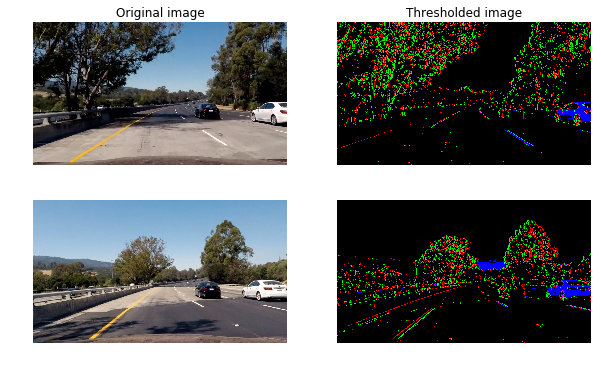

In [6]:
test_DIR = "test_images/"
test_imgs = glob(os.path.join(test_DIR,"*.jpg"))[:2]
nrows = len(test_imgs)
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
for ax in axes.flatten() :
    ax.axis('off')
for img,ax in zip(test_imgs, axes) :
    img = mpimg.imread(img)
    img = cal.undistort_img(img)
    ax[0].imshow(img)
    lane = lane_detection(img)
    channels = lane.split_channels()
    imgA = np.dstack((channels['edge_pos'], channels['edge_neg'], channels['white_tight']))
    imgB = np.dstack((channels['yellow_edge_pos'], channels['yellow_edge_neg'], channels['yellow']))
    ax[1].imshow(imgA)
    #ax[2].imshow(imgB)
axes[0,0].set_title('Original image')
axes[0,1].set_title('Thresholded image')

From the above images, it can be seen that using positive and negative gradients allows us to differentiate between lane lines from shadow lines and other irrelevant road markings. Concretely, for lane lines, positive and negative threshold lines always appear together.
Here are the results for applying gradient thresholds on 'S' channel and yellow color selection:

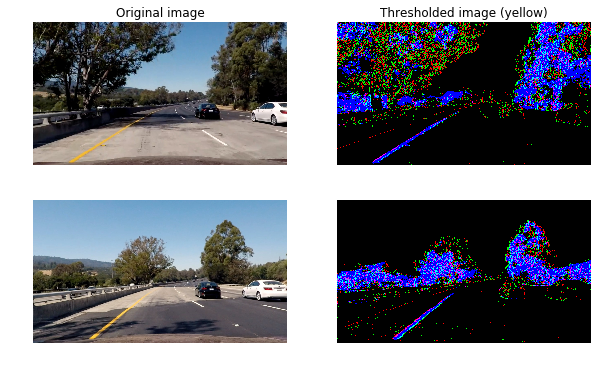

In [7]:
test_DIR = "test_images/"
test_imgs = glob(os.path.join(test_DIR,"*.jpg"))[:2]
nrows = len(test_imgs)
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
for ax in axes.flatten() :
    ax.axis('off')
for img,ax in zip(test_imgs, axes) :
    img = mpimg.imread(img)
    img = cal.undistort_img(img)
    ax[0].imshow(img)
    lane = lane_detection(img)
    channels = lane.split_channels()
    imgA = np.dstack((channels['edge_pos'], channels['edge_neg'], channels['white_tight']))
    imgB = np.dstack((channels['yellow_edge_pos'], channels['yellow_edge_neg'], channels['yellow']))
    ax[1].imshow(imgB)
    #ax[2].imshow(imgB)
axes[0,0].set_title('Original image')
axes[0,1].set_title('Thresholded image (yellow)')

### Perspective transform
The code for my perspective transform includes a function called `lane_detection.warper()`. The source and destination points were chosen as follows:

| Source        | Destination   |
| ------------- |:-------------:| 
| (225,700)     | (320,720)     |
| (590,450)     | (320,-100)    |
| (690,450)     | (960,-100)    |
| (1055,700)    | (960,720)     |

I verified that my perspective transform was working as expected by drawing the source and destination points onto test images and its warped counterpart to verify that the lines appear parallel in the warped image. 

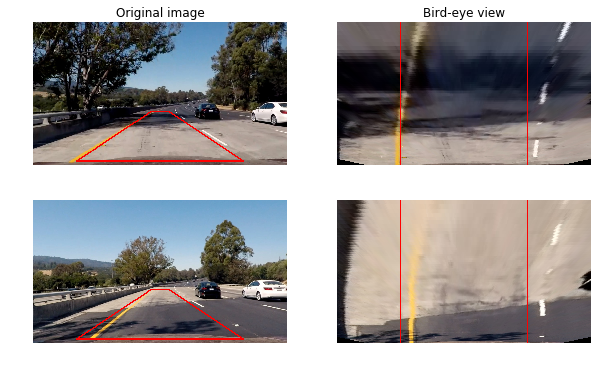

In [8]:
test_DIR = "test_images/"
test_imgs = glob(os.path.join(test_DIR,"*.jpg"))[:2]
nrows = len(test_imgs)
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
for ax in axes.flatten() :
    ax.axis('off')
for img,ax in zip(test_imgs, axes) :
    img = mpimg.imread(img)
    img = cal.undistort_img(img)
    lane = lane_detection(img)
    annotated_img, warped = lane.warper(debug=True)
    ax[0].imshow(annotated_img)
    ax[1].imshow(warped)
axes[0,0].set_title('Original image')
axes[0,1].set_title('Bird-eye view')

### Lane detection
Two approaches were implemented for finding lane lines. The first approach is the window sliding method which is used when prior lane information does not exist or missing. Although this appraoch is often more robust, it is also computationally time consuming. The other approach is searching for lane pixels in a target region determined by the previous window frame. The second approach is less compuationally intensive and is used for most of the video frames. 

The window sliding method is implemented in `lane_detection.sliding_window()` function using 15 windows for each side of the lane. Information from all 7 channels of the thresholding step is utilized. For example, I require that positive gradient edges be accompanied by negative gradient edges, which allows for differentiating lane markings from shadows. Here are the results on a test image :

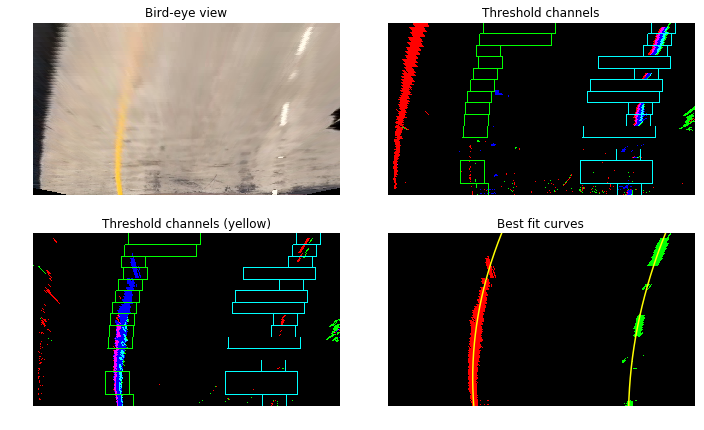

In [9]:
test_DIR = "test_images/"
img = glob(os.path.join(test_DIR,"*.jpg"))[3]
nrows = 2 #len(test_imgs)
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
for axis in ax.flatten() :
    axis.axis('off')
img = mpimg.imread(img)
img = cal.undistort_img(img)
lane = lane_detection(img)
imgA,imgB,imgC = lane.sliding_window(debug=False)
ax[0,0].imshow(lane.warper())
ax[0,1].imshow(imgA)
ax[1,0].imshow(imgB)
ax[1,1].imshow(imgC)
h,w = imgC.shape[:2]
x_fit,y = lane.plot_curve_fits()
if x_fit['left'] is not None:
    ax[1,1].plot(x_fit['left'],y,color='yellow')
if x_fit['right'] is not None:
    ax[1,1].plot(x_fit['right'],y,color='yellow')
ax[1,1].set_xlim(0,w)
ax[1,1].set_ylim(h,0)
ax[0,0].set_title('Bird-eye view')
ax[0,1].set_title('Threshold channels')
ax[1,0].set_title('Threshold channels (yellow)')
ax[1,1].set_title('Best fit curves')
plt.tight_layout()

In order to fit curves to "good" pixels, I have used `numpy.polyfit` function to fit a second order polynomial, implementation of which can be found in the function `lane_detection.curve_fit()`. Concretely, the best fit curves are parametrized as follows :
$$x = A y^2 + B y + C$$

Once the lane pixels have been detected using sliding window method, a targeted search is performed in subsequent video frames by focusing on region around the best fit curves from the previous frame. Here is an example :

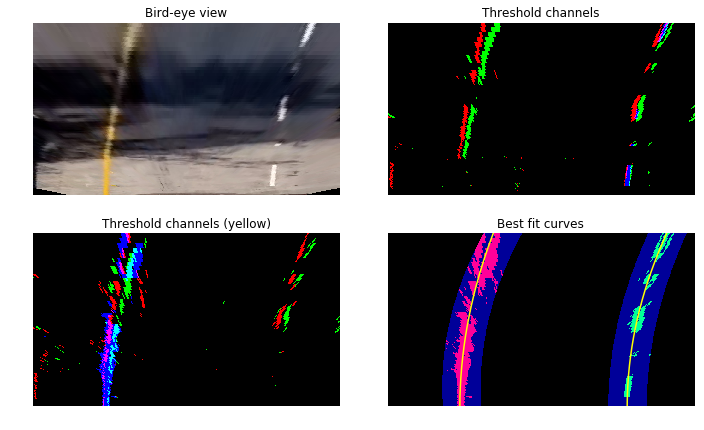

In [10]:
test_DIR = "test_images/"
img = glob(os.path.join(test_DIR,"*.jpg"))[0]
nrows = 2 #len(test_imgs)
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
for axis in ax.flatten() :
    axis.axis('off')
img = mpimg.imread(img)
img = cal.undistort_img(img)
#ax[0].imshow(img)
lane = lane_detection(img)
imgA,imgB,imgC = lane.sliding_window(debug=False)
_,fit = lane.curve_fit()
ax[0,0].imshow(lane.warper())
imgA,imgB,imgC = lane.target_search(fit)
ax[0,1].imshow(imgA)
ax[1,0].imshow(imgB)
ax[1,1].imshow(imgC)
h,w = imgC.shape[:2]
x_fit,y = lane.plot_curve_fits()
if x_fit['left'] is not None:
    ax[1,1].plot(x_fit['left'],y,color='yellow')
if x_fit['right'] is not None:
    ax[1,1].plot(x_fit['right'],y,color='yellow')
ax[1,1].set_xlim(0,w)
ax[1,1].set_ylim(h,0)
ax[0,0].set_title('Bird-eye view')
ax[0,1].set_title('Threshold channels')
ax[1,0].set_title('Threshold channels (yellow)')
ax[1,1].set_title('Best fit curves')
plt.tight_layout()

In [11]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
img_dim = (1280, 720)

class lane_line :
    def __init__(self, n_iter=8) :
        # number of iterations to use for avraging/smoothing
        self.n_iter = n_iter
        # was the line detected in the last iteration?
        self.detected = False
        # counter
        self.counter = 0
        
        
        # x values of the current and last n fits of the line
        self.current_xfitted = None 
        self.recent_xfitted = [] 
        self.avg_xfitted = None
        self.yfitted = np.linspace(0, img_dim[1]-1, img_dim[1])
        
        # polynomial coefficients of the current and last n iterations
        self.current_fit = None
        self.recent_fits = []
        self.avg_fit = None
        self.res = None # residuals from fit
        
        self.current_pixels = None
        self.previous_pixels = []
        self.radius_of_curvature = None
        self.line_base_pos = None
        # x values for detected line pixels
        self.pixels_x = None
        # y values for detected line pixels
        self.pixels_y = None
        
    def add_line(self,x_pixels, y_pixels) :
        self.detected = True
        self.counter += 1
        self.pixels_x = x_pixels
        self.pixels_y = y_pixels
        self.curve_fit()
        self.calc_R(self.current_fit)
        self.calc_base_dist(self.current_fit)
        
    def curve_fit(self, poly_order=2):
        fit, self.res,_,_,_ = np.polyfit(self.pixels_y, self.pixels_x, poly_order, full=True)
        self.res = self.res/len(self.pixels_x)**1.2
        self.poly_order=poly_order
        self.current_fit = fit
        
        h = img_dim[1]
        y = self.yfitted
        x_fit = fit[poly_order]
        for i in range(poly_order) :
            x_fit += fit[i]*y**(poly_order-i)
        self.current_xfitted = x_fit
        if self.avg_xfitted is None :
            self.update()
            
    def calc_R(self, fit) :
        y=img_dim[1]
        self.radius_of_curvature = ((ym_per_pix**2 + xm_per_pix**2*(2*fit[0]*y + fit[1])**2)**1.5)/(2
                                    *xm_per_pix*ym_per_pix*fit[0])
    
    def calc_base_dist(self, fit) :
        y = img_dim[1]
        dist = -img_dim[0]/2
        for i in range(self.poly_order+1) :
            dist += fit[i]*y**(self.poly_order-i)
        self.line_base_pos = dist*xm_per_pix
            
    def update(self) :
        if len(self.recent_fits) >= self.n_iter : 
            self.recent_xfitted.pop(0)
            self.recent_fits.pop(0)
        
        #n_iter = len(self.recent_fits)+1
        #weights = np.array([(i+1)/n_iter for i in range(n_iter)])/sum([i+1 for i in range(n_iter)])
        self.recent_xfitted.append(self.current_xfitted)
        self.avg_xfitted = np.average(np.array(self.recent_xfitted), axis=0)
        #self.avg_xfitted = np.average(np.array(self.recent_xfitted), axis=0, weights=weights)
        self.recent_fits.append(self.current_fit)
        self.avg_fit = np.average(np.array(self.recent_fits), axis=0)
        #self.avg_fit = np.average(np.array(self.recent_fits), axis=0, weights=weights)
        self.calc_R(self.avg_fit)
        self.calc_base_dist(self.avg_fit)
        self.detected = False
        
    def radius_ratio(self, other_line) :
        delta_r = abs(self.radius_of_curvature-other_line.radius_of_curvature)
        min_r = min(abs(self.radius_of_curvature),abs(other_line.radius_of_curvature))
        return delta_r/min_r
    
    def check_diverging_curves(self, other_line):
        R1 = self.radius_of_curvature
        R2 = other_line.radius_of_curvature
        if max(abs(R1), abs(R2)) > 1500 :
            return False
        else :
            return (R1*R2<0) 
    
    def fit_ratio(self, other_line):
        fit1 = np.array(self.current_fit)
        fit2 = np.array(other_line.current_fit)
        delta_fit = fit1-fit2
        min_fit = np.minimum(np.absolute(fit1), np.absolute(fit2)) 
        return np.linalg.norm(delta_fit[:2]/min_fit[:2])*2000/(
            abs(self.radius_of_curvature) + abs(other_line.radius_of_curvature))
    
    def base_gap(self, other_line):
        return abs(self.line_base_pos-other_line.line_base_pos)
    
    def delta_xfitted(self):
            return np.linalg.norm(self.current_xfitted - self.avg_xfitted)

### Lane parameters
To calculate lane parameters, measurement units have to be changed from pixels to real world units such as meter. I use the following conversion : $k_x=3.7/700$ m/pixel in the x-direction and $k_y=30/720$ m/pixel.

* Radius of curvature : The radius of curvature is implemented in `lane_line.calc_R()` function in ******. Since, the original fit was performed in the pixel space, I use the following formula for conversion to real world space :
	$$ R = \frac{(k_x^2 + k_y^2(2Ay+B)^2)^{3/2}}{2 k_x k_y |A|}$$ 
	
* To find the position of the vehicle with respect to the center, I calculate the x-coordinate of both the left and right lane lines with repect to the center at the base of the image. The average of the two x-coordinates is the position of the center of the road with respect to the camera center. 

In [12]:
line = {'left':lane_line(), 'right':lane_line()}
fail = {'left':2, 'right':2}

def pipeline(img) :
    img = cal.undistort_img(img)
    (h,w) = img.shape[:2] 
    lane = lane_detection(img)
    imgA = np.zeros_like(img)
    imgB = np.zeros_like(img)
    imgC = np.zeros_like(img)
    main_img = np.zeros_like(img).astype(np.uint8)
    if line['left'].counter%10==0 or line['right'].counter%10==0 or \
        line['left'].counter<10 or line['right'].counter<10 or \
        fail['left']>=2 or fail['right']>=2 :
        #print("using window ")
        imgA,imgB,imgC = lane.sliding_window()
    else :
        fit = {}
        for side in ['left','right'] :
            #print("using target ", side, line[side].avg_fit )
            fit[side] = line[side].avg_fit
        imgA,imgB,imgC = lane.target_search(fit)
        
    fit = {'left':None, 'right':None}    
    sides = ['left','right']
    

    for side in sides :
        if not lane.found[side] :
            fail[side]+=1
            line[side].detected=False
        else :
            pixels_x, pixels_y = lane.good_pixels_x, lane.good_pixels_y
            line[side].add_line(pixels_x[side], pixels_y[side])
            line[side].detected=True
    #print(line['left'].fit_ratio(line['right']),line['left'].base_gap(line['right']))
    if line['left'].check_diverging_curves(line['right']) or line['left'].fit_ratio(line['right'])>10 \
            or (not 400*xm_per_pix<line['left'].base_gap(line['right'])<750*xm_per_pix) :
        #print(line[side].delta_xfitted())
        for side in sides :
            #print("delta", line[side].delta_xfitted())
            #if line[side].delta_xfitted() > 500  :
            if line[side].delta_xfitted() > 1000 or line[side].res > 55: 
                fail[side] += 1
            else :
                line[side].update()
    else :
        for side in sides :
            if line[side].res > 55  :
                fail[side] +=1
            elif line[side].detected : 
                fail[side]=0
                line[side].update()
            
    
    for side in sides :  
        fit[side] = line[side].avg_fit
        pts = np.array(np.vstack((line[side].avg_xfitted, line[side].yfitted)).T, dtype=np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(imgC,[pts],False,(255,255,0), thickness=5)
        
        pts = np.array(np.vstack((line[side].current_xfitted, line[side].yfitted)).T, dtype=np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(imgC,[pts],False,(0,255,255), thickness=2)
        line[side].calc_R(line[side].avg_fit)
        line[side].calc_base_dist(line[side].avg_fit)

    R_avg = (line['left'].radius_of_curvature + line['right'].radius_of_curvature)/2
    base_gap = (line['left'].base_gap(line['right']))
    center_pos = (line['left'].line_base_pos + line['right'].line_base_pos)/2

    main_img = lane.plot_lane(fit)
    img_A = cv2.resize(imgA,None, fx=0.32, fy=0.34, interpolation=cv2.INTER_AREA)
    hA,wA = img_A.shape[:2]
    img_B = cv2.resize(imgB,None, fx=0.32, fy=0.34, interpolation=cv2.INTER_AREA)
    hB,wB = img_B.shape[:2]
    img_C = cv2.resize(imgC,None, fx=0.32, fy=0.34, interpolation=cv2.INTER_AREA)
    text_A = np.zeros((hA/4, wA,3))
    h_text = text_A.shape[0] 
    text_B = np.zeros((h_text, wA,3))
    text_C = np.zeros((h_text, wA,3))
    for i in range(1,3) :
        text_A[:,:,i] = 255
        text_B[:,:,i] = 255
        text_C[:,:,i] = 255
    text_A = text_A.astype(np.uint8)
    text_B = text_B.astype(np.uint8)
    text_C = text_C.astype(np.uint8)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(text_A,'Threshold',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
    cv2.putText(text_B,'Threshold (yellow)',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
    cv2.putText(text_C,'Best fit',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
    img_combined_right = np.vstack((text_A,img_A,text_B, img_B, text_C, img_C))
    main_text = np.zeros((3*h_text+3*hA-h,w,3)).astype(np.uint8)
    h_main_text, w_main_text = main_text.shape[:2]
    cv2.putText(main_text,'Radius of curvature : {:5.2f} m'.format(abs(R_avg)),
                (10,35), font, 1,(255,255,255),3,cv2.LINE_AA)
    shift = "left" if center_pos>0 else "right"
    cv2.putText(main_text,'Vehicle is {:6.2f} m {:5} of center'.format(abs(center_pos), shift),
                (10,80), font, 1,(255,255,255),3,cv2.LINE_AA)
    if line['left'].avg_fit[0]>0.0001 and  line['right'].avg_fit[0]>0.0001 :
        cv2.putText(main_text,'Right curve ahead',
                (10,135), font, 1,(0,255,255),3,cv2.LINE_AA)
    elif line['left'].avg_fit[0]<-0.0001 and  line['right'].avg_fit[0]<-0.0001 :
        cv2.putText(main_text,'Left curve ahead',
                (10,135), font, 1,(0,255,255),3,cv2.LINE_AA)
    img_combined_left = np.vstack((main_img, main_text))
    return np.hstack((img_combined_left, img_combined_right))

To store the history of video frames, I have implemented a class `lane_line`. The final pipeline is implemented in the function `pipeline(img)` which takes as input video frame `img`. In this function, I toggle between two methods for finding lane line pixels : window sliding method is used for the first few frames and every 10th frame while a targetted search is used when lane markings were found in the previous video frame. Further, I have implemented averaging of the fit parameters over last few iterations so as to avoid jittery lines.

Here are a couple sample outputs : 

image #  1


/home/esmat/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


image #  2


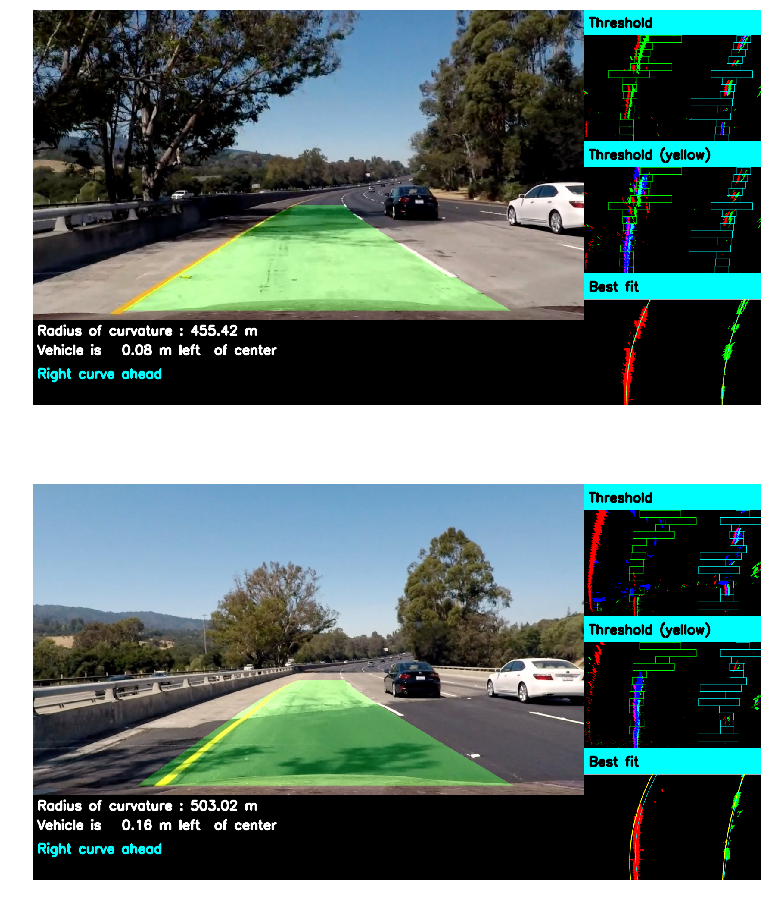

In [13]:
line = {'left':lane_line(), 'right':lane_line()}
fail = {'left':2, 'right':2}

test_DIR = "test_images/"
test_imgs = glob(os.path.join(test_DIR,"*.jpg"))[:2]
nrows = len(test_imgs)
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(20*ncols,8*nrows))
for i,(img,ax) in enumerate(zip(test_imgs, axes)) :
    print("image # ",i+1)
    img = mpimg.imread(img)
    ax.imshow(pipeline(img))
    ax.axis('off')

### Final video

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
line = {'left':lane_line(n_iter=7), 'right':lane_line(n_iter=7)}
fail = {'left':3, 'right':3}

output = 'output_video/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [07:16<00:00,  2.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 13min 34s, sys: 34.9 s, total: 14min 9s
Wall time: 7min 17s


In [16]:
line = {'left':lane_line(n_iter=7), 'right':lane_line(n_iter=7)}
fail = {'left':3, 'right':3}

output = 'output_video/challenge_video.mp4'
clip = VideoFileClip("challenge_video.mp4")
clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/challenge_video.mp4
[MoviePy] Writing video output_video/challenge_video.mp4


100%|██████████| 485/485 [02:49<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challenge_video.mp4 

CPU times: user 5min 16s, sys: 13.3 s, total: 5min 29s
Wall time: 2min 50s
